# One-page figure plot pipeline

This pipeline is currently being built to easily generate single-system full-page figures for Jack Schulte's MEEP I / Cargo III paper.

The full-page figures generated by this pipeline include a stacked transit plot, RV vs. Time, RV vs. Phase, SED, and a MIST evolutionary track plot. This pipeline only works with outputs from EXOFASTv2. To generate these figures, lots of input files (or output files from EXOFASTv2) are needed. These files are listed below:
- All of the 'mcmc.detrendedmodel' files from the transits
- All of the 'mcmc.prettymodel' files from the transits
- All of the 'mcmc.residuals' files from the transits
- The 'mcmc.model.telescope_##' files from each of the RV telescopes
- The 'mcmc.rv.ps.prettymodelrv.planet' file
- The 'mcmc.sed.residuals.txt' file
- The 'median.csv' file
- The 'mcmc.idl' file (the IDL save file for the fit)

## Imports

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
import astropy.constants as const
from matplotlib.colors import Normalize as Normalize
import matplotlib.cm
import scipy.interpolate as interpolate
from scipy import stats
from matplotlib.gridspec import GridSpec
import os
from pdf2image import convert_from_path
from scipy.io import readsav

## The Pipeline

In [44]:
def t_phase_folded(t, per, t0):
    t_phase_folded = (t - t0)/per - np.floor((t - t0)/per + 0.5) # centers on zero
    return t_phase_folded

def gen1pagefig(object_name, lcnames, rvnames, path = 'data/', file_prefix = '.MIST.SED.', external_MIST = False):
    '''
    object_name: a string containing the planet's name. Ex: '1855' for toi-1855

    lcnames: array of strings naming the telescopes used to collect the light curves in order of the observation date. If it is
    a tess light curve, write TESS and then the exposure time in seconds. Ex: ['TESS 1800', 'SOAR']

    rvnames: array of strings with the names of the instruments that obtained the RVs in alphabetical order. Ex: ['CHIRON (fiber)', 'CHIRON (slicer)']

    path: a string containing the path to the input files. by default, it is assumed that the files are in a folder labeled 'data/' within the working directory.

    file_prefix: a string containing the prefix that the EXOFASTv2 output files have, following the object name. Ex: '.MIST.SED.'

    external_MIST: a boolean to determine whether or not an external PDF figure of the MIST evolution plot is being used
    '''

    # Determining which TESS data are being used
    TESS_exptimes = []
    for x in lcnames:
        if 'TESS' in x:
            TESS_exptimes.append(str([int(s) for s in x.split() if s.isdigit()][0]))
    TESS_exptimes = [exptime for i, exptime in enumerate(TESS_exptimes) if exptime not in TESS_exptimes[:i]] # removing duplicates

    # LOADING IN DATA

    # loading median file
    median = pd.read_csv(f'{path}{object_name}{file_prefix}median.csv')

    period_median = float(median[' median value'][median['#parname'] == 'Period_0']) * u.day
    t14_median = float(median[' median value'][median['#parname'] == 't14_0']) * u.day
    t14_median = (t14_median.to(u.hr)).value
    planetmass_median = float(median[' median value'][median['#parname'] == 'mp_0'])
    planetradius_median = float(median[' median value'][median['#parname'] == 'rp_0'])
    eccentricity_median = float(median[' median value'][median['#parname'] == 'e_0'])

    # Extracting best-fit parameters from mcmc sav files

    savfile = readsav(f'{path}{object_name}{file_prefix}mcmc.idl')
    mcmcss = savfile['mcmcss']
    slope_best = mcmcss.star[0].slope[0].best[0]
    if np.isnan(slope_best) == True:
        slope_best = 0
    period_best = mcmcss.planet[0].period[0].best[0] * u.day
    epoch_best = mcmcss.planet[0].tc[0].best[0] * u.day
    rvepoch_best = mcmcss.rvepoch[0] # for some reason the best-fit rv epoch isn't labeled as such
    t14_best = mcmcss.planet[0].t14[0].best[0] * u.day
    t14_best = (t14_best.to(u.hr)).value
    

    for i in range(len(rvnames)): # should we be using the best-fit gamma and jitter?
        gamma_varname = f'gamma_{i}'
        jitter_varname = f'jitter_{i}'

        locals()[gamma_varname] = float(median[' median value'][median['#parname'] == f'gamma_{i}']) # assigning new variable gamma_{i}
        locals()[jitter_varname] = float(median[' median value'][median['#parname'] == f'jitter_{i}'])

    # loading mcmc transit files

    model_names = ['time', 'flux']
    residual_names = ['time', 'residuals', 'error']

    pretty_TESS_1800 = pd.DataFrame(columns=model_names)
    detrended_TESS_1800 = pd.DataFrame(columns=model_names)
    residuals_TESS_1800 = pd.DataFrame(columns=residual_names)

    pretty_TESS_600 = pd.DataFrame(columns=model_names)
    detrended_TESS_600 = pd.DataFrame(columns=model_names)
    residuals_TESS_600 = pd.DataFrame(columns=residual_names)

    pretty_TESS_120 = pd.DataFrame(columns=model_names)
    detrended_TESS_120 = pd.DataFrame(columns=model_names)
    residuals_TESS_120 = pd.DataFrame(columns=residual_names)

    followup_name_index = [] # initializing follow-up lc name index to assign names at the end
    f = 0 # integer required to track the number of follow-up lightcurves

    for i in range(len(lcnames)):
        lc_index = f'{i:03d}'
        pretty_model = pd.read_csv(f'{path}{object_name}{file_prefix}mcmc.prettymodel.transit_{lc_index}.planet_00.txt', sep='\s+', header=None, names=model_names)
        detrended_model = pd.read_csv(f'{path}{object_name}{file_prefix}mcmc.detrendedmodel.transit_{lc_index}.planet_00.txt', sep='\s+', header=None, names=model_names)
        residual = pd.read_csv(f'{path}{object_name}{file_prefix}mcmc.residuals.transit_{lc_index}.txt', sep='\s+', header=None, names=residual_names)

        if lcnames[i] == 'TESS 1800':
            pretty_TESS_1800 = pd.concat([pretty_TESS_1800, pretty_model], ignore_index = True)
            detrended_TESS_1800 = pd.concat([detrended_TESS_1800, detrended_model], ignore_index = True)
            residuals_TESS_1800 = pd.concat([residuals_TESS_1800, residual], ignore_index = True)
        elif lcnames[i] == 'TESS 600':
            pretty_TESS_600 = pd.concat([pretty_TESS_600, pretty_model], ignore_index = True)
            detrended_TESS_600 = pd.concat([detrended_TESS_600, detrended_model], ignore_index = True)
            residuals_TESS_600 = pd.concat([residuals_TESS_600, residual], ignore_index = True)
        elif lcnames[i] == 'TESS 120':
            pretty_TESS_120 = pd.concat([pretty_TESS_120, pretty_model], ignore_index = True)
            detrended_TESS_120 = pd.concat([detrended_TESS_120, detrended_model], ignore_index = True)
            residuals_TESS_120 = pd.concat([residuals_TESS_120, residual], ignore_index = True)         
        else:
            pretty_varname = f'pretty_followup_{f}'
            detrended_varname = f'detrended_followup_{f}'
            residuals_varname = f'residuals_followup_{f}'
            locals()[pretty_varname] = pretty_model # assigning new variable pretty_followup_{f} = pretty_model
            locals()[detrended_varname] = detrended_model
            locals()[residuals_varname] = residual
            followup_name_index.append(i)
            f += 1

    for i in range(len(rvnames)):
        residuals_rv_varname = f'residuals_rv_{i}'
        model_rv_varname = f'model_rv_{i}'

        model_names_rv = ['time', 'rv']
        pretty_rv = pd.read_csv(f'{path}{object_name}{file_prefix}mcmc.rv.ps.prettymodelrv.planet.00.txt', sep='\s+', names=model_names_rv)
        pretty_rv['rv_trend'] = pretty_rv.rv + slope_best * (pretty_rv.time - rvepoch_best) # accounting for slope
        pretty_rv['phase'] = ((pretty_rv.time - epoch_best)/period_best.value) - np.floor((pretty_rv.time - epoch_best)/period_best.value+0.5)
        pretty_rv_phasesorted = pretty_rv.sort_values('phase')

        residuals_names_rv = ['time', 'residual', 'error']
        locals()[residuals_rv_varname] = pd.read_csv(f'{path}{object_name}{file_prefix}mcmc.residuals.telescope_0{i}.txt', sep='\s+', names=residuals_names_rv)
        locals()[residuals_rv_varname]['phase'] = ((locals()[residuals_rv_varname].time - epoch_best)/period_best.value)\
              - np.floor((locals()[residuals_rv_varname].time - epoch_best)/period_best.value+0.5)
        locals()[model_rv_varname] = pd.read_csv(f'{path}{object_name}{file_prefix}mcmc.model.telescope_0{i}.txt', sep='\s+', names=model_names_rv)

    # Loading in SED data
    sed_cols = ['filtername', 'wavelength', 'model_flux', 'measured_flux', 'upper_error', 'lower_error', 'residual']
    sed_residuals = pd.read_csv(f'{path}{object_name}{file_prefix}mcmc.sed.residuals.txt', sep='\s+', skiprows=1, header=None, names = sed_cols)

    # MANIPULATING DATA

    # Generating lightcurves for the TESS data
    dic_TESS_1800 = {'time': detrended_TESS_1800.time, 'flux': detrended_TESS_1800.flux + residuals_TESS_1800.residuals + 1}
    lc_TESS_1800 = pd.DataFrame(dic_TESS_1800)
    dic_TESS_600 = {'time': detrended_TESS_600.time, 'flux': detrended_TESS_600.flux + residuals_TESS_600.residuals + 1}
    lc_TESS_600 = pd.DataFrame(dic_TESS_600)
    dic_TESS_120 = {'time': detrended_TESS_120.time, 'flux': detrended_TESS_120.flux + residuals_TESS_120.residuals + 1}
    lc_TESS_120 = pd.DataFrame(dic_TESS_120)

    # Generating lightcurves for the followup data
    for i in range(len(followup_name_index)):
        detrended_varname = f'detrended_followup_{i}'
        residuals_varname = f'residuals_followup_{i}'
        lc_varname = f'lc_followup_{i}'
        dic_followup = {'time': locals()[detrended_varname].time, 'flux': locals()[detrended_varname].flux + locals()[residuals_varname].residuals + 1}
        locals()[lc_varname] = pd.DataFrame(dic_followup)

    # Phase-folding the TESS data
    for exptime in TESS_exptimes:
        lc_varname = 'lc_TESS_' + exptime
        pretty_varname = 'pretty_TESS_' + exptime
        locals()[lc_varname].time = t_phase_folded(locals()[lc_varname].time, period_best, epoch_best)*period_best.to(u.hr)
        locals()[pretty_varname].time = t_phase_folded(locals()[pretty_varname].time, period_best, epoch_best)*period_best.to(u.hr)

    # Phase-folding the followup data
    for i in range(len(followup_name_index)):
        lc_varname = f'lc_followup_{i}'
        pretty_varname = f'pretty_followup_{i}'
        locals()[lc_varname].time = t_phase_folded(locals()[lc_varname].time, period_best, epoch_best)*period_best.to(u.hr)
        locals()[pretty_varname].time = t_phase_folded(locals()[pretty_varname].time, period_best, epoch_best)*period_best.to(u.hr)

    # # binning the data
    # binwidth = t14 / 10

    # nbins_TESS = int((np.max(lc_TESS.time) - np.min(lc_TESS.time))/binwidth)

    # lc_TESS_binned_time = stats.binned_statistic(lc_TESS.time, lc_TESS.time, bins = nbins_TESS)[0]
    # lc_TESS_binned_flux = stats.binned_statistic(lc_TESS.time, lc_TESS.flux, bins = nbins_TESS)[0]

    # nbins_followup = int((np.max(lc_followup.time) - np.min(lc_followup.time))/binwidth)

    # lc_followup_binned_time = stats.binned_statistic(lc_followup.time, lc_followup.time, bins = nbins_followup)[0]
    # lc_followup_binned_flux = stats.binned_statistic(lc_followup.time, lc_followup.flux, bins = nbins_followup)[0]

    # # median combining and cleaning up the TESS model
    # pretty_TESS = pretty_TESS.sort_values('time')
    # pretty_TESS_binned_time = stats.binned_statistic(pretty_TESS.time, pretty_TESS.time, bins = nbins_TESS * 2)[0]
    # pretty_TESS_binned_flux = stats.binned_statistic(pretty_TESS.time, pretty_TESS.flux, bins = nbins_TESS * 2)[0]

    # Calculating RVs
    for i in range(len(rvnames)):
        rvs_varname = f'rvs_{i}'
        rvs_trendsubtracted_varname = f'rvs_trendsubtracted_{i}'
        rvs_error_varname = f'rv_error_{i}'
        model_rv_varname = f'model_rv_{i}'
        residuals_rv_varname = f'residuals_rv_{i}'

        gamma_varname = f'gamma_{i}'
        jitter_varname = f'jitter_{i}'

        locals()[rvs_trendsubtracted_varname] = locals()[model_rv_varname].rv + locals()[residuals_rv_varname].residual - locals()[gamma_varname]\
              - slope_best * (locals()[residuals_rv_varname].time - rvepoch_best) # subtracting linear slope
        locals()[rvs_varname] = locals()[model_rv_varname].rv + locals()[residuals_rv_varname].residual - locals()[gamma_varname]
        locals()[rvs_error_varname] = (locals()[residuals_rv_varname].error**2 + locals()[jitter_varname])**(1/2)
    
    # Bandpass effective widths to represent the errors of the SED plot (from the SVO filter profile service)
    # [Gaia G, Gbp, Grp, 2MASS J, H, Ks, WISE W1, W2, W3]
    Weff = np.array([4203.61, 2333.06, 2842.11, 1624.32, 2509.40, 2618.87, 6626.42, 10422.66, 55055.23]) * u.AA
    Weff = (Weff.to(u.micron)).value

    # PLOTTING

    # defining a list of colors to choose from when plotting. Feel free to change or add more!
    colors = ['#009B77', '#821EA6', '#34568B', '#D1AF19', '#95DEE3', '#88B04B', '#955251', '#5B5EA6', '#9B2335', '#E6AF91', '#D65076', '#422C7A', '#DD4124']

    # Setting up the figure
    fig, axs = plt.subplots(ncols=2, nrows=3)
    fig.set_figheight(20)
    fig.set_figwidth(17)
    fig.suptitle(f'{object_name}\n', fontsize=20, fontweight='bold')
    fig.text(0.5, 0.95, f'$P$ = {round(period_median.value, 3)} d | $R_P$ = {planetradius_median} R$_J$ | $M_P$ = {planetmass_median} M$_J$ | $e$ = {eccentricity_median}', ha='center'\
             , fontsize=17)   

    # Making the top left plot take up two spaces
    gs = axs[0, 0].get_gridspec()
    # remove the underlying axes
    for ax in axs[0:2, 0]:
        ax.remove()
    ax1 = fig.add_subplot(gs[0:2, 0])

    # Transits (top left)
    TESS_lc_index = 0 # keeps track of the TESS lightcurves to space each lightcurve
    for exptime in TESS_exptimes:
        pretty_varname = 'pretty_TESS_' + exptime
        lc_varname = 'lc_TESS_' + exptime
        locals()[pretty_varname].sort_values('time', inplace=True) # sorting model

        # separates each lightcurve by 0.025
        ax1.plot(locals()[pretty_varname].time, locals()[pretty_varname].flux + 1 - 0.025 * TESS_lc_index, c = 'k', zorder=2, linewidth=3)
        ax1.scatter(locals()[lc_varname].time, locals()[lc_varname].flux - 0.025 * TESS_lc_index, ls = 'None', c=colors[TESS_lc_index], s = 100, alpha = 0.7, \
                edgecolors='#000000', zorder = 1, label = 'TESS ' + exptime + 's')
        # tess=ax1.scatter(lc_TESS_binned_time, lc_TESS_binned_flux, ls = 'None', c='#9F3BC2', s = 125, alpha = 1, \
                # edgecolors='#000000', zorder = 10, label='TESS')
        TESS_lc_index += 1

    for i in range(len(followup_name_index)):
        pretty_varname = f'pretty_followup_{i}'
        lc_varname = f'lc_followup_{i}'

        locals()[pretty_varname].sort_values('time', inplace=True) # sorting model

        ax1.plot(locals()[pretty_varname].time, locals()[pretty_varname].flux + 1 - 0.025 * (i + TESS_lc_index), c = 'k', zorder=2, linewidth=3)
        ax1.scatter(locals()[lc_varname].time, locals()[lc_varname].flux - 0.025 * (i + TESS_lc_index), ls = 'None', c=colors[i + len(TESS_exptimes)], s = 100, alpha = 0.7, \
                edgecolors='#000000', zorder = 1, label = lcnames[followup_name_index[i]])
        # followup=ax1.scatter(lc_followup_binned_time, lc_followup_binned_flux-0.025, ls = 'None', c='#7BA2F1', \
                # s = 125, alpha = 1, edgecolors='#000000', zorder = 10, label='TFOP')

    ax1.legend(loc = 4, fontsize = 15) # add legend row for EXOFASTv2 model?

    xmin = -t14_best/2 - 1 # setting x limits based on the transit duration
    xmax = t14_best/2 + 1
    ax1.set_xlim([xmin,xmax])
    ymin = 1 - 0.025 * (i + TESS_lc_index + 1)
    ymax = 1.0125
    ax1.set_ylim([ymin, ymax])

    ax1.set_xlabel('Time Since Conjunction [Hours]', fontsize = 20)
    ax1.set_ylabel('Normalized Flux', fontsize = 20)

    ax1.tick_params(which = 'both', direction = 'inout')
    ax1.tick_params(labelsize = 20, length = 10, width=2)
    ax1.tick_params(which = 'minor', length = 7, width = 1)
    ax1.tick_params(which='both')

    # RVs vs. Time (top right)

    axs[0, 1].remove()
    nested_gs = gs[0, 1].subgridspec(2, 1, height_ratios=[1, 0.4], hspace=0)
    ax2_upper = fig.add_subplot(nested_gs[0])
    ax2_lower = fig.add_subplot(nested_gs[1])

    ax2_upper.set_xlim(np.min(pretty_rv.time - 2457000),np.max(pretty_rv.time - 2457000))
    ax2_lower.set_xlim(np.min(pretty_rv.time - 2457000),np.max(pretty_rv.time - 2457000))
    ax2_lower.set_xlabel('Time [BJD$_{\mathrm{TDB}} - 2457000$]', fontsize = 20)
    ax2_upper.set_ylabel('RV [m/s]', fontsize = 20)
    ax2_lower.set_ylabel('O-C [m/s]', fontsize = 16)

    ax2_upper.tick_params(which = 'major', direction = 'inout',labelsize = 20, length = 10, width=2,axis='y')
    ax2_lower.tick_params(which = 'major', direction = 'inout',labelsize = 20, length = 10, width=2)

    ax2_upper.plot(pretty_rv.time - 2457000, pretty_rv.rv_trend, c = 'k', zorder=10, lw = 0.5, label = 'EXOFASTv2', alpha=0.7)

    max_rv = [] # keeping track of the max and min rv from each dataset to set plot limits
    min_rv = []
    for i in range(len(rvnames)):
        residuals_rv_varname = f'residuals_rv_{i}'
        rvs_varname = f'rvs_{i}'
        rvs_error_varname = f'rv_error_{i}'

        max_rv.append(np.max(locals()[rvs_varname]))
        min_rv.append(np.min(locals()[rvs_varname]))

        ax2_upper.errorbar(locals()[residuals_rv_varname].time - 2457000, locals()[rvs_varname], yerr=locals()[rvs_error_varname], fmt='o', mfc=colors[-(i+1)], \
                        mec='k', ecolor=colors[-(i+1)], capsize=4, ls='None', label=rvnames[i])
        ax2_lower.errorbar(locals()[residuals_rv_varname].time - 2457000, locals()[residuals_rv_varname].residual, yerr=locals()[rvs_error_varname], \
                        fmt='o', mfc=colors[-(i+1)], mec='k', ecolor=colors[-(i+1)], capsize=4, ls='None')
    
    ax2_upper.set_ylim(np.min(min_rv) - 100, np.max(max_rv) + 100)
    ax2_lower.axhline(0, ls='--', c='grey', lw = 2)
    ax2_upper.legend(fontsize = 15)

    # RVs vs. Phase (bottom right)

    axs[1, 1].remove()
    nested_gs = gs[1, 1].subgridspec(2, 1, height_ratios=[1, 0.4], hspace=0)
    ax3_upper = fig.add_subplot(nested_gs[0])
    ax3_lower = fig.add_subplot(nested_gs[1])
    ax3_upper.set_xlim(-0.5, 0.5)
    ax3_lower.set_xlim(-0.5, 0.5)
    ax3_lower.set_xlabel('Phase', fontsize = 20)
    ax3_upper.set_ylabel('RV [m/s]', fontsize = 20)
    ax3_lower.set_ylabel('O-C [m/s]', fontsize = 16)

    ax3_upper.tick_params(which = 'major', labelsize = 20, length = 10, width=2, axis='y')
    ax3_lower.tick_params(which = 'major', direction = 'inout', labelsize = 20, length = 10, width=2)

    ax3_upper.plot(pretty_rv_phasesorted.phase, pretty_rv_phasesorted.rv, c = 'k', zorder=10, lw = 2, label = 'EXOFASTv2', alpha=0.7)

    for i in range(len(rvnames)):
        residuals_rv_varname = f'residuals_rv_{i}'
        rvs_varname = f'rvs_{i}'
        rvs_trendsubtracted_varname = f'rvs_trendsubtracted_{i}'
        rvs_error_varname = f'rv_error_{i}'

        ax3_upper.errorbar(locals()[residuals_rv_varname].phase, locals()[rvs_trendsubtracted_varname], yerr=locals()[rvs_error_varname], \
                           fmt='o', mfc=colors[-(i+1)], mec='k', ecolor=colors[-(i+1)], capsize=4, ls='None', label=rvnames[i])
        ax3_lower.errorbar(locals()[residuals_rv_varname].phase, locals()[residuals_rv_varname].residual, yerr=locals()[rvs_error_varname], fmt='o', mfc=colors[-(i+1)], mec='k',\
                ecolor=colors[-(i+1)], capsize=4, ls='None')

    ax3_lower.axhline(0, ls='--', c='grey', lw = 2)
    ax3_upper.legend(fontsize = 15)

    # SED Plot (bottom left)

    axs[2, 0].remove()
    nested_gs = gs[2, 0].subgridspec(2, 1, height_ratios=[1, 0.4], hspace=0)
    ax4_upper = fig.add_subplot(nested_gs[0])
    ax4_lower = fig.add_subplot(nested_gs[1])
    ax4_upper.set_ylabel('Flux [erg s$^{-1}$ cm$^{-2}$]', fontsize = 20)
    ax4_lower.set_xlabel('Wavelength [$\mu$m]', fontsize = 20)
    ax4_lower.set_ylabel('O-C [erg s$^{-1}$ cm$^{-2}$]', fontsize = 16)

    ax4_upper.tick_params(which = 'major', direction = 'inout',labelsize = 20, length = 10, width=2, axis='y')
    ax4_upper.set_xticks([])
    ax4_lower.tick_params(which = 'major', direction = 'inout',labelsize = 20, length = 10, width=2)

    ax4_upper.errorbar(sed_residuals.wavelength, sed_residuals.measured_flux, yerr=[sed_residuals.lower_error, sed_residuals.upper_error],\
                       xerr=Weff, fmt='.', markersize=8, mfc='#ff3126', mec='#ff3126',\
                       ecolor='#ff3126', capsize=4, ls='None', label = 'Observations') # Are x errors the width of the wavelength band or where do we get these?

    ax4_upper.scatter(sed_residuals.wavelength, sed_residuals.model_flux, marker='o', color='k', label='EXOFASTv2')

    ax4_lower.errorbar(sed_residuals.wavelength, sed_residuals.residual, yerr=[sed_residuals.lower_error, sed_residuals.upper_error],\
                       xerr=Weff, fmt='.', markersize=8, mfc='#ff3126', mec='#ff3126',\
                       ecolor='#ff3126', capsize=4, ls='None', label = 'Observations') # Are x errors the width of the wavelength band or where do we get these?

    ax4_lower.axhline(0, ls='--', color='grey', lw = 2)
    # ax4_lower.set_ylim(-3e-11, 3e-11)
    ax4_upper.set_yscale('log')
    ax4_upper.set_xscale('log')
    ax4_lower.set_xscale('log')

    ax4_upper.legend(fontsize = 15)

    # MIST Plot (bottom right)
    if external_MIST == True:
        ax5 = axs[2, 1]
        mist = convert_from_path(f'mist/{object_name}_mist.pdf')
        ax5.imshow(mist[0])

        ax5.set_xlim(100, 1470)
        ax5.set_ylim(1000, 20)
        ax5.set_xlabel(r'T$_{\rm eff}$ (K)', fontsize = 20)
        ax5.set_ylabel('log g$_*$ (cgs)', fontsize = 20)

        # Remove all axis elements except for the labels
        ax5.set_yticklabels([])
        ax5.set_xticklabels([])
        ax5.set_xticks([])
        ax5.set_yticks([])
        plt.setp(ax5.spines.values(), visible=False)

    # Add some space between subplots
    plt.tight_layout(pad=2.5, h_pad=1)

    # Saves the figure to your local directory in a subdirectory named 'output'
    if os.path.exists('output') == False:
        os.mkdir('output')
    plt.savefig(f'output/fullpagefig_{object_name}.png', bbox_inches='tight')

## Workspace

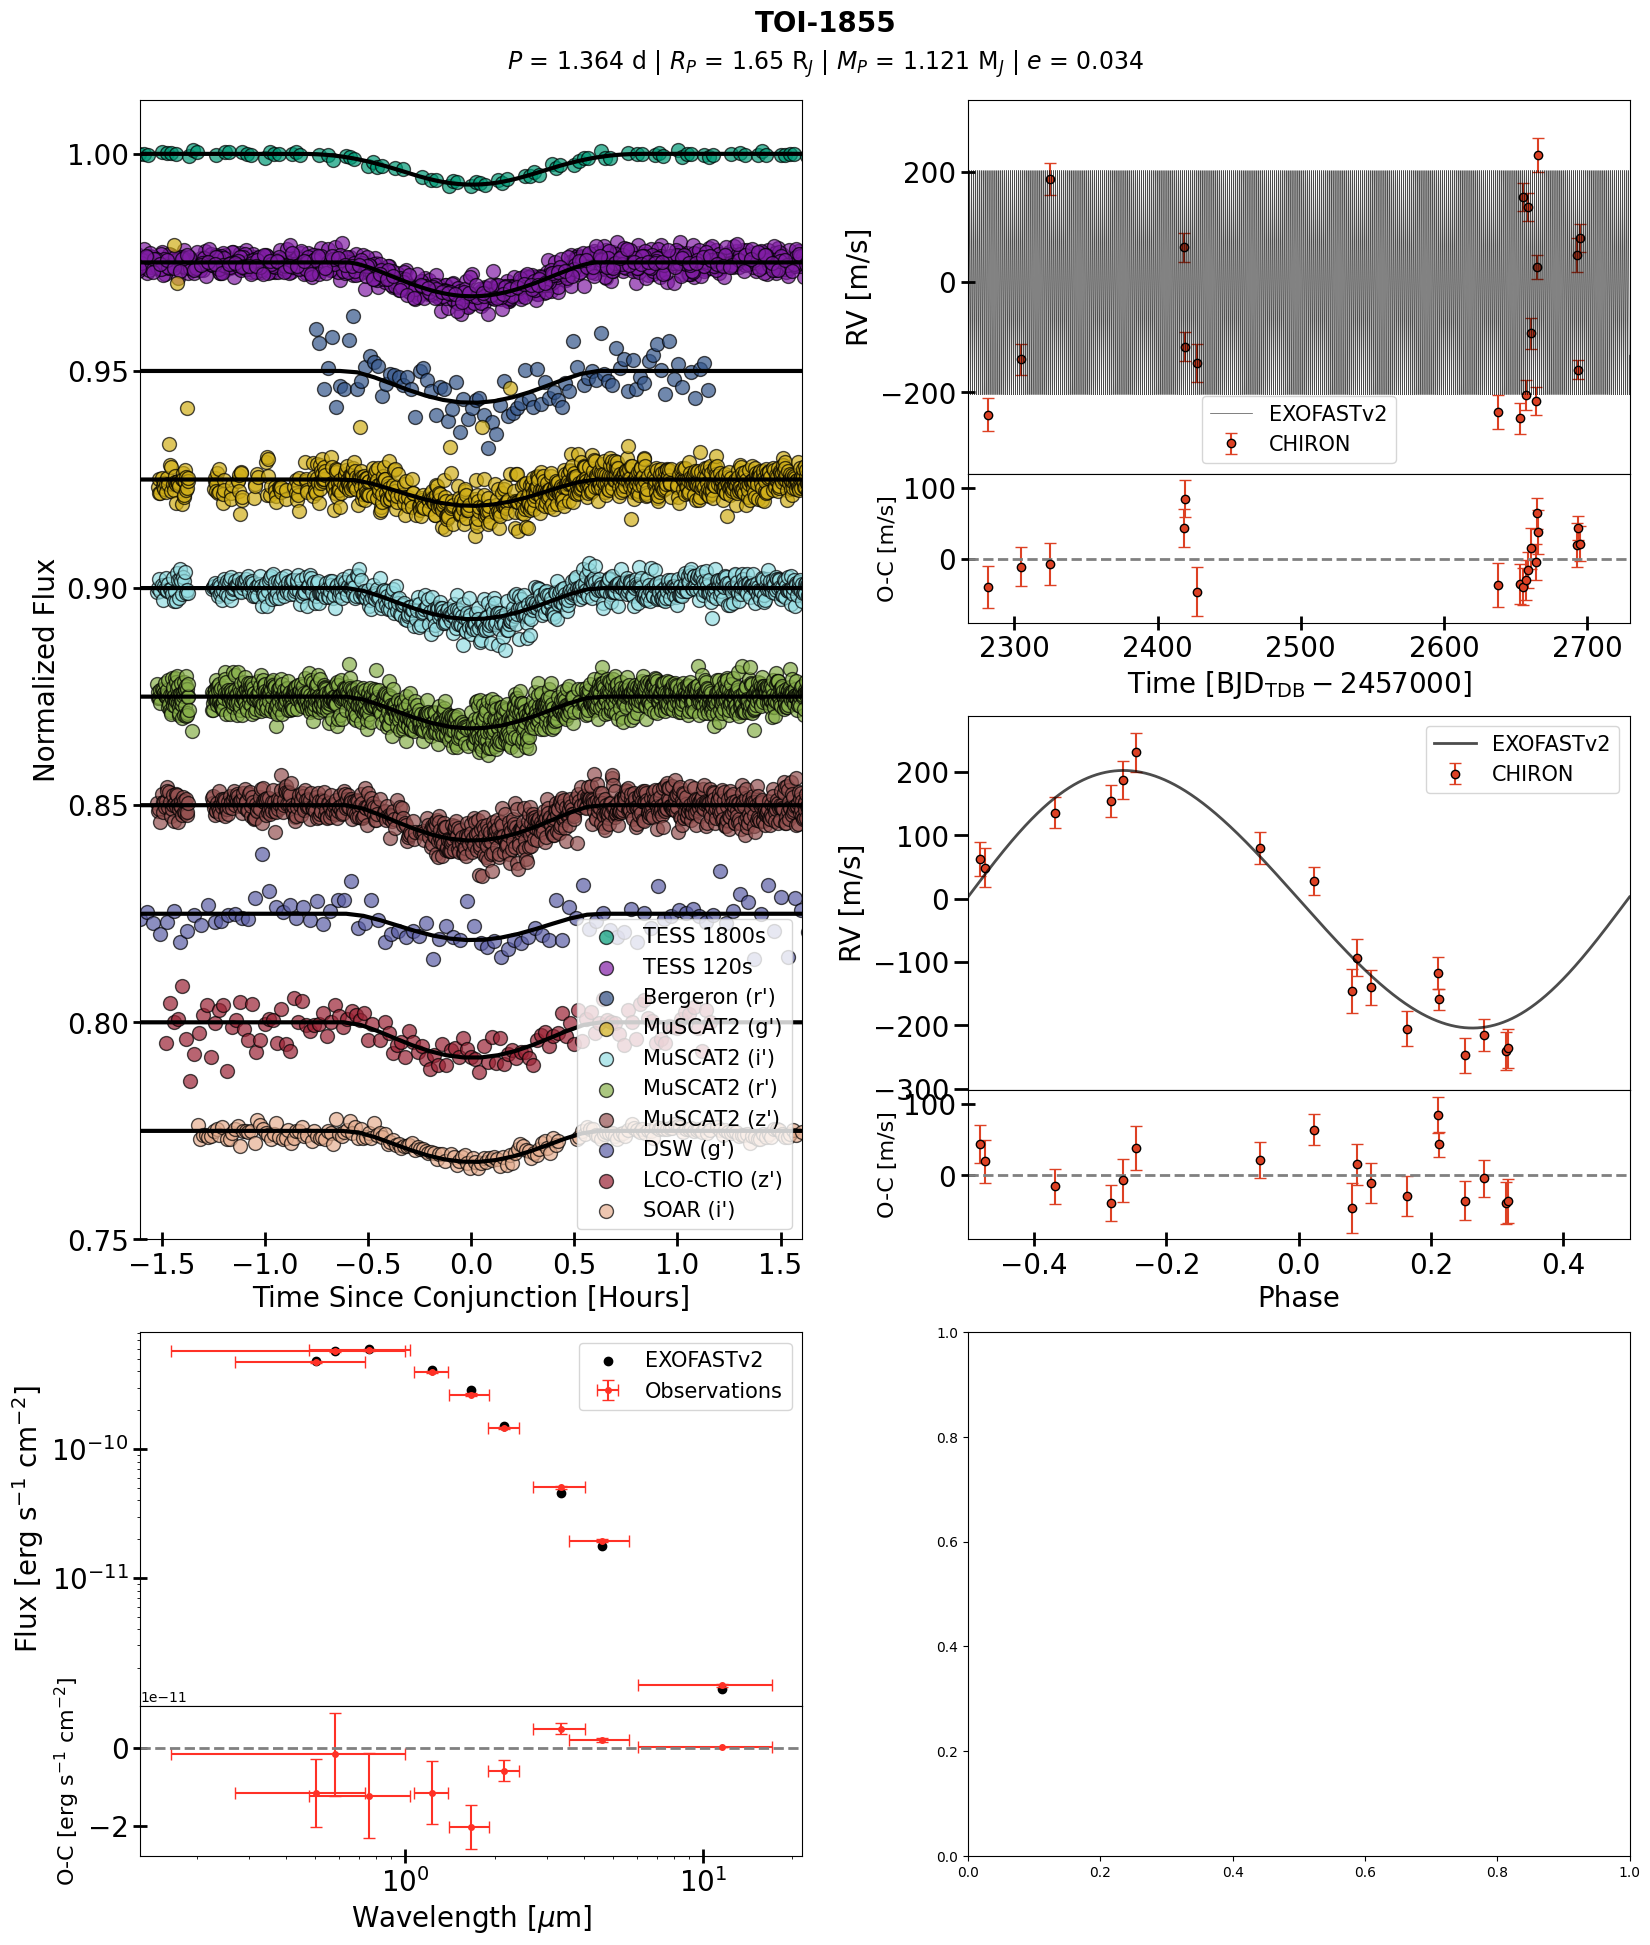

In [45]:
# Lightcurve file names for Cargo 3 targets
lcnames_1855 = ['TESS 1800', 'Bergeron (r\')', 'MuSCAT2 (g\')', 'MuSCAT2 (i\')', 'MuSCAT2 (r\')', 'MuSCAT2 (z\')', 'DSW (g\')', 'LCO-CTIO (z\')', 'TESS 120', 'SOAR (i\')']
lcnames_2107 = ['TESS 1800', 'LCO-SSO (i\')', 'TESS 600', 'LCO-SAAO (g\')', 'LCO-SAAO (z\')', 'TRAPPIST-South (B)']
lcnames_2368 = ['TESS 1800', 'TESS 1800', 'El Sauce (R)', 'Hwd (R)', 'TESS 600', 'LCO-SSO (g\')', 'LCO-SSO (i\')', 'TESS 600', 'SOAR (i\')', 'TESS 120', \
    'TESS 120', 'LCO-CTIO 27s (i\')', 'LCO-CTIO 40s (i\')']
lcnames_3129 = ['TESS 1800', 'TESS 600', 'Brierfield (R)', 'LCO-CTIO (i\')', 'SOAR (i\')']
lcnames_5301 = ['TESS 1800', 'TESS 600', 'TESS 600', 'KeplerCam (i\')']

# RV instruments
rvnames_2107 = ['CHIRON (fiber)', 'CHIRON (slicer)']

# Running the pipeline
object_name = 'TOI-1855'
rvnames = ['CHIRON']
gen1pagefig(object_name, lcnames_1855, rvnames)

### Things I need to do:
- Update SED plot
    - Add in functionality to choose whether or not to plot the stellar atmosphere
    - Mess around with IDL and make the atmosphere files
- Remake the MIST plot w/ python